In [10]:
# based on https://notebook.community/Python4AstronomersAndParticlePhysicists/PythonWorkshop-ICE/notebooks/10_03_Astronomy_PhotUtils
%matplotlib inline
from astropy              import units as u
from astropy              import wcs
from astropy.io           import fits
from astropy.coordinates  import SkyCoord
from astropy.modeling     import models, fitting
from astropy.stats        import sigma_clipped_stats, SigmaClip

from photutils            import DAOStarFinder, CircularAperture, aperture_photometry, CircularAnnulus
from photutils.background import Background2D, MedianBackground
from photutils.utils      import calc_total_error

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

# set default matplotlib parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 13

# let's make a function that makes our code cleaner for visualization:
from astropy.visualization import ZScaleInterval
def display(data, cb_title=''):
    norm = ZScaleInterval()
    vmin, vmax = norm.get_limits(data)
    plt.imshow(data, vmin=vmin, vmax=vmax, interpolation='none', origin='lower')
    plt.colorbar(label=cb_title)

def get_bkg(img, sigma=3.0, maxiters=5):
    """ 
        Estimate background  statistics (median and standard deviation) 
        of a fits image after applying a sigma-clipping routine
        
        Parameters:
           img (numpy.ndarray): input image
           sigma (float, optional):  number of standard deviations to use for both the lower and upper clipping limit (default=3.0)
           maxiters (int, optional): maximum number of sigma-clipping iterations to perform (default=5)
           
        Returns:
           median, std (float): the median, and standard deviation of the sigma-clipped data
    """
    mean, median, std = sigma_clipped_stats(img, sigma=sigma, maxiters=maxiters)    
    return median, std

def get_pixelscale(img_wcs, pixscale=None):
    """ 
        Return the pixel scale of a fits image
        
        Parameters:
           img_wcs (astropy.wcs.wcs.WCS): input WCS from the fits file
           pixscale (float, optional): if pixel scale not found, use the provided value instead (in arcseconds)
           
        Returns:
           pixscale (float): the pixel scale of the image (in arcseconds)
    """
    if pixscale is None:
        pixelscale = np.mean(wcs.utils.proj_plane_pixel_scales(img_wcs) * u.degree).to('arcsec')
    else:
        pixelscale = pixscale * u.arcsec
        
    return pixelscale.value

def find_stars(img, fwhm=15., sigma_thresh=5.0):
    """
        Uses DAOPhot implementations to detect sorces with a given FWHM and above a detection limit.
        
        Parameters:
           img (numpy.ndarray): input image
           fwhm (float, optional): expected FWHM for the sources (in pixels, default=15)
           sigma_thresh (float, optional): detection limit (in sigmas, default=5.0)
           
        Returns:
           table_detections (astropy.table.table.QTable): table of results containing the following columns:
               ['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
        
    """
    
    bkg, std_bkg = get_bkg(img)
    
    daofind = DAOStarFinder(fwhm=fwhm_sources, threshold=sigma_thresh * std_bkg)
    
    table_detections = daofind(img - bkg)    

    print("A total of {} sources were detected above a {:.1f}-sigma threshold".format(len(table_detections),sigma_thresh))
    print("")
    
    return table_detections


def displ_table(table, format_cols='%.8g', max_rows=-1, max_cols=-1):
    """
        Set basic definitions to print an Astropy Table on screen
        
        Parameters:
           table (astropy.table.table.QTable): table to print
           format_cols (str, optional): set formating for all tables for consistent output (default='%.8g')
           max_rows (int, optional): maximum number of rows to print (default=-1, all)
           max_cols (int, optional): maximum number of columns to print (default=-1, all)
           
        Returns:
           print the table on screen, no variables to return.
        
    """
    for cols in table.colnames: table[cols].info.format = format_cols  # for consistent table output
    # print entire table
    print(table.pprint(max_lines=max_rows, max_width=max_cols))
    
def get_fwhm(img, table_sources, source_id=5, pixscale=10, stamp_radius=50, psf_model='moffat', fwhm_best_guess = 1.5, plot_results=False):
    """
        Fit the FWHM of a point like source using a Gaussian or Moffat profile
        
        Parameters:
           img (numpy.ndarray): input image
           table_sources (astropy.table.table.QTable): table of sources from find_stars()
           source_id (in, optional): id of the source to analyse (default=5)
           pixscale (float): the pixel scale of the image (in arcseconds, default=10)
           stamp_radius (int, optional): size of the grid to analyze the star (default=50)
           psf_model (str, optional): 'moffat' or 'gaussian' model (default='moffat')
           fwhm_best_guess (float, optional): if using a 'gaussian' profile. provide the best guess for the FWHM (in arcseconds)
           plot_results (bool, optional): print out the results on screen
           
        Returns:
           fwhm (astropy.units.quantity.Quantity): the FWHM of the point source (in arcseconds)
        
    """

    # select a bright (not saturated) source for PSF modelling:
    isource = table_sources[source_id]

    # High SN - 50
    # Low SN - 33
    # Non-uniform background - 78

    if plot_results:
        print ("x pos: " + str(isource['xcentroid']))
        print ("y pos: " + str(isource['ycentroid']))

    # show the source in a 100x100 region
    if plot_results:
        display(img[int(isource['ycentroid'] - stamp_radius):
                    int(isource['ycentroid'] + stamp_radius), 
                    int(isource['xcentroid'] - stamp_radius): 
                    int(isource['xcentroid'] + stamp_radius)])
        plt.show()
    
    median, std_bkg = get_bkg(img)

    # Median bkg subtracted image
    img_nobkg = img - median

    # turn the 2D profile into a 1D distance array from the center of each pixel to the centroid of the source estimated by DAO Phot:
    flux_counts = []
    pixel_distance = []

    x_cen = int(isource['xcentroid'])
    y_cen = int(isource['ycentroid'])

    # Pixels around detection loop
    analysis_radius = int(np.round(0.33*stamp_radius))
    for x in range(x_cen - analysis_radius, x_cen + analysis_radius):
        for y in range(y_cen - analysis_radius, y_cen + analysis_radius):
            flux_counts.append(((img_nobkg[y][x]) / isource['peak']))
            pixel_distance.append(np.linalg.norm((isource['xcentroid'] - x, isource['ycentroid'] - y)))

    if psf_model == 'gaussian':
        # Fit the data using a Gaussian
        model_init = models.Gaussian1D(amplitude=1.0, mean=0, stddev=fwhm_best_guess)
    elif psf_model == 'moffat':
        # Fit the data using a Moffat
        model_init = models.Moffat1D(amplitude=1.0, x_0=0, gamma=2., alpha=3.5)
    else:
        raise Exception("Unknown model type: %s. Must be gaussian or moffat." % psf_model)

    fitter     = fitting.SimplexLSQFitter()
    fitted_psf = fitter(model_init, pixel_distance, flux_counts)

    print ("Fit value: {:.8g}".format(fitter.fit_info['final_func_val']))
    print ("      SNR: {:.8g}".format(np.sqrt(isource['flux'])))

    # FHWM conversion
    if psf_model == 'gaussian':
        fwhm_fit = 2.355 * fitted_psf.stddev * pixscale
    elif psf_model == 'moffat':
        fwhm_fit = fitted_psf.gamma * 2 * np.sqrt(2 ** (1. / fitted_psf.alpha) - 1) * pixscale
    else:
        raise Exception("Unknown model type: %s. Must be gaussian or moffat." % psf_model)

    print (" Fit FWHM: {:.8g}".format(fwhm_fit))

    # Check fitting
    color = 'green' if fitter.fit_info['final_func_val'] < 5.0 else 'red'

    # Plot the data with the best-fit model
    plt.figure()
    plt.plot(pixel_distance, flux_counts, 'ko')
    rx = np.linspace(0, int(max(pixel_distance)), int(max(pixel_distance)) * 10)
    plt.plot(rx,
             fitted_psf(rx),
             color=color,
             lw=3.0,
             label='SNR: %.2f, Fit: %.2f, FWHM: %.2f"' % (np.sqrt(isource['flux']),
                                                          fitter.fit_info['final_func_val'],
                                                          fwhm_fit))
    plt.xlabel('Distance (pixels)')
    plt.ylabel('Normalized flux (ADU)')
    plt.title('%s profile fit' % psf_model)
    plt.legend()
    plt.show()
    
    return fwhm_fit
    

def get_bkg2d(img, bkg_box=34, filter_size=3, plot_results=False):
    """
        Estimate a 2d background using an input fits image
        
        Parameters:
           img (numpy.ndarray): input image
           bkg_box (int, optional): The box size along each axis (default=34)
           filter_size (int, optional): The window size of the 2D median filter to apply to the low-resolution background map. (default=3)
           plot_results (bool, optional): print out the results on screen
           
        Returns:
           fwhm (astropy.units.quantity.Quantity): the FWHM of the point source (in arcseconds)
        
    """

    sigma_clip = SigmaClip(sigma=3., maxiters=10)
    bkg_estimator = MedianBackground()
    bkg = Background2D(img, (bkg_box, bkg_box), filter_size=(filter_size, filter_size),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    if plot_results:
        display(bkg.background)
        plt.show()

    return bkg.background


def do_phot(img, positions, bkg=None, gain=1., exptime=1., r_in=10, r_out=None):
    """
        Perform aperture photometry on an input fits image
        
        Parameters:
           img (numpy.ndarray): input image
           positions (numpy.array): array of (x,y) values for extracting the photometry 
           bkg (numpy.ndarray, optional): input background estimate (default=None)
           gain (float, optional): ratio of counts to the units of img to calculate the Poisson error of the sources.
                                   If gain is zero, then the source Poisson noise component will not be included (default=1.)
           exptime (float, optional): exposure time of the observations in seconds (default=1.)
           r_in (float, optional): radius of the circle to measure the flux. (in pixels, default=10)
           r_out (float, optional): the outer radius of the circular annulus (in pixels, default=None)
           
        Returns:
           table_phot (astropy.table.table.QTable): table of results containing the following columns:
               ['id', 'xcenter', 'ycenter', 'aperture_sum', 'aperture_error', 'annulus_sum', 'annulus_error',
                'aperture_sum_nobkg', 'aperture_sum_nobkg_error', 'SNR']
    """
    
    if bkg is not None:
        img_nobkg = img - bkg
        # remove nan values from background
        bkg[np.isnan(bkg)]=0.0
        bkg_error = np.sqrt(abs(bkg))
        phot_error = calc_total_error(img, bkg_error, gain)
        
        img = img_nobkg
        #display(phot_error[0:800, 0:800])
        #plt.show()
    
    # if no r_out is provided, perform simple aperture photometry
    aper_in = CircularAperture(positions, r=r_in)
    if r_out is not None: annulus_apertures = CircularAnnulus(positions, r_in=r_in, r_out=r_out)
    
    apertures = aper_in
    if r_out is not None: apertures = [aper_in,annulus_apertures]
    
    if bkg is None:
        table_phot = aperture_photometry(img, apertures)
    else:
        table_phot = aperture_photometry(img, apertures, error=phot_error)
    
    # remove background using the annulus
    if r_out is not None: 
        table_phot.rename_column('aperture_sum_0', 'aperture_sum')
        table_phot.rename_column('aperture_sum_1', 'annulus_sum')
        table_phot.rename_column('aperture_sum_err_0', 'aperture_error')
        table_phot.rename_column('aperture_sum_err_1', 'annulus_error')

        # Use the aperture_sum_1 to estimate the level of background around the source. We need to know the area of the annulus for this estimation:
        bkg_mean = table_phot['annulus_sum'] / annulus_apertures.area
        # Now remove the background estimation to all pixels in the aperture:
        bkg_aper = bkg_mean * aper_in.area
        flux_nobkg = table_phot['aperture_sum'] - bkg_aper
        
        
        err_ap = table_phot['aperture_error']  / aper_in.area
        err_an = table_phot['annulus_error']  / annulus_apertures.area
        err_nobkg = np.sqrt(err_ap**2+err_an**2)*aper_in.area
        
        table_phot['aperture_sum_nobkg'] = flux_nobkg
        table_phot['aperture_sum_nobkg_error'] = err_nobkg
        #table_phot['aperture_sum_nobkg_error'] = table_phot['aperture_error']
        table_phot['SNR'] = table_phot['aperture_sum_nobkg'] / table_phot['aperture_sum_nobkg_error']
    else:
        table_phot.rename_column('aperture_sum_err', 'aperture_error')
        
        table_phot['SNR'] = table_phot['aperture_sum'] / table_phot['aperture_error']
        
    # now plot
    display(img[0:800, 0:800])
    if r_out is not None: annulus_apertures.plot(color='purple', lw=2, alpha=1)
    aper_in.plot(lw=2, ls=':', color='white')
    plt.show()
    
    return table_phot


def table_xy2sky(table, img_wcs, exptime=1., zp=25.):
    """
        Read photometric table from do_phot() and converts (x,y) position and flux values to sky (RA,Dec) and magnitudes
        
        Parameters:
           table (astropy.table.table.QTable): table from do_phot()
           img_wcs (astropy.wcs.wcs.WCS): input WCS from the fits file
           exptime (float, optional): exposure time of the observations in seconds (default=1.)
           zp (float, optional): the photometric zero-point offset to be added to the instrumental magnitudes (default=25.)
           
        Returns:
           table_out (astropy.table.table.QTable): table of results containing the following columns:
               ['id', 'ra', 'dec', 'm', 'e_m', 'SNR']
        
    """
    
    # prepare the output list
    # convert (x,y) to (RA,Dec)
    coords_xy = np.array([table['xcenter'], table['ycenter']]).T
    coords_wcs = img_wcs.all_pix2world(coords_xy,0)
    
    table_out = table.copy()
    table_out['ra'], table_out['dec'] = coords_wcs[:,0], coords_wcs[:,1]
    
    # if errors are provided, run:
    if 'aperture_sum_nobkg_error' in table_out.colnames: 
        table_out['m'] = zp -2.5 * np.log10(table_phot['aperture_sum_nobkg']/exptime)
        table_out['e_m'] = np.sqrt( ( ( 2.5 / np.log(10) ) * table_phot['aperture_sum_nobkg_error'] / table_phot['aperture_sum_nobkg'] )**2 )
        table_out.remove_columns(['xcenter','ycenter','aperture_sum','aperture_error','annulus_sum','annulus_error','aperture_sum_nobkg','aperture_sum_nobkg_error'])

    else:
        table_out['m'] = zp -2.5 * np.log10(table_phot['aperture_sum']/exptime)
        table_out['e_m'] = np.sqrt( ( ( 2.5 / np.log(10) ) * table_phot['aperture_error'] / table_phot['aperture_sum'] )**2 )
        table_out.remove_columns(['xcenter','ycenter','aperture_sum','aperture_error'])

    table_out = table_out['id','ra','dec','m','e_m','SNR']
    return table_out
    
print('Packages loaded.')

Packages loaded.


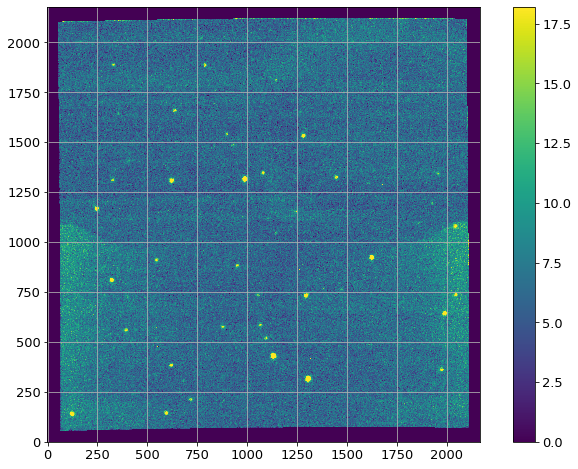

In [5]:
###################################################################################
infolder = 'D:/SOAR/SAM/SO2022B-014/results/NGC121_A_2022-10-17/'

filename = 'NGC121_A_B.fits'

# remove '.fits' if existing
filename = infolder+filename.rsplit('.fits', 1)[0]

# open the fits file
with fits.open(filename+'.fits') as hdu:
    hdr = hdu[0].header
    img = hdu[0].data
    img_wcs = wcs.WCS(hdr)

# replace Nan by zeros, if any
img[np.isnan(img)] = 0

# divide image by exposure time (ADU) -> (ADU/sec)
#img /= hdr['EXPTIME']
#cb_title='flux (ADU/sec)'

display(img)
plt.grid('on')
plt.show()


# Object detections
Using DAOPhot routines

A total of 84 sources were detected above a 3.0-sigma threshold

 id xcentroid ycentroid sharpness   roundness1   roundness2  npix sky     peak       flux        mag     
--- --------- --------- ---------- ------------ ------------ ---- --- ----------- --------- -------------
  1 74.678274 62.856981 0.22236685   0.45500756  0.054040602  441   0 0.026904106  3.283026    -1.2906858
  2 2101.7167 78.757524 0.20894689   -0.2118734 -0.030514157  441   0  0.11211157 3.7131502    -1.4243563
  3 1507.9038 91.253236  0.4041478   0.14944389  -0.29240419  441   0   1.1977301 1.0069552 -0.0075253276
...       ...       ...        ...          ...          ...  ... ...         ...       ...           ...
 82 1120.2805 2060.2188 0.79694049   0.31142554  0.034502609  441   0   4.5703511 1.8118686   -0.64531673
 83 62.746209 2099.8747  0.4581782 -0.086214016  -0.55820862  441   0    3.538198 4.8932864    -1.7240016
 84 1762.1763 2104.4703 0.26313015   0.17098917   0.94471123  441   0   1.1832676 1.064

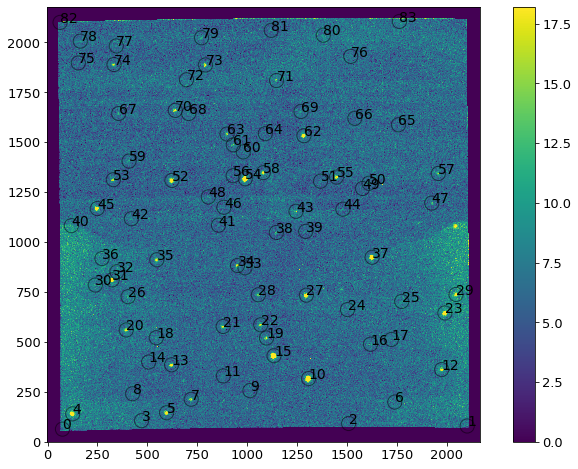

Fit value: 2.195173
      SNR: 8.8453935
 Fit FWHM: 1.0939579


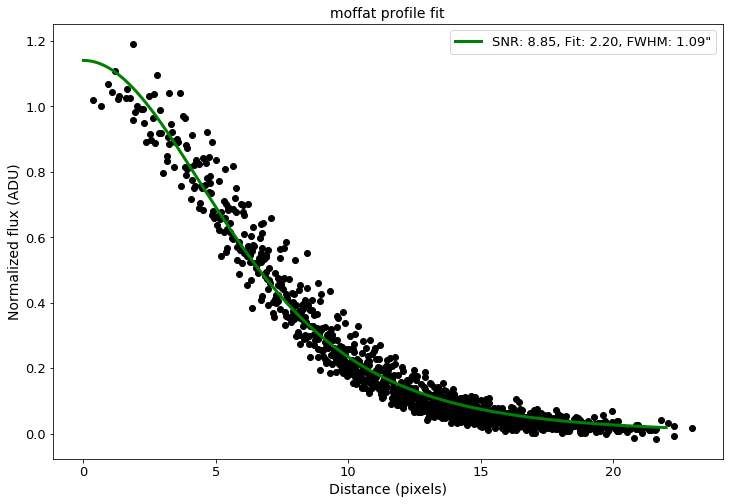

In [6]:
pixscale = get_pixelscale(img_wcs)

# Object detection
fwhm_sources = ( 1.5 / pixscale ) # in pixels
sigma_det = 3.0

# run DAOFind to detect stars
sources = find_stars(img, fwhm=fwhm_sources, sigma_thresh=sigma_det)

displ_table(sources, max_rows=10)

# show image with detections
display(img)
plt.scatter(sources['xcentroid'], sources['ycentroid'], s=200, alpha=0.5, facecolors='none', edgecolors='black')
# display id's
txt_id = sources['id']-1
x = sources['xcentroid']
y = sources['ycentroid']
for i, txt in enumerate(txt_id):
    plt.annotate(txt, (x[i], y[i]))
plt.show()

# get the FWHM of the PSF
fwhm_psf = get_fwhm(img, sources, pixscale=pixscale, source_id=10, stamp_radius=50)

# Background modelling
For non-uniform background, the constant median can be insuficient. 

Produce a 2D model of the background to be subtracted from the original image to improve the modelling of the stars

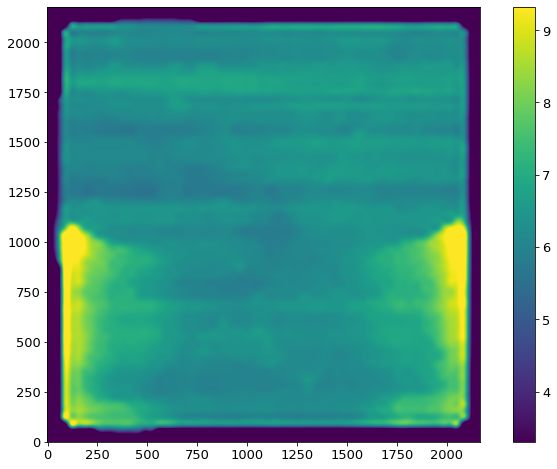

In [7]:
# background modelling
bkg2d = get_bkg2d(img, bkg_box=34, plot_results=True)

aperture_radius: 21.902970581358748


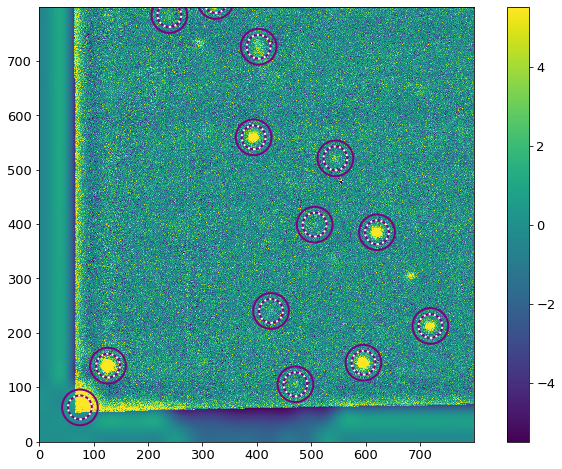

 id  xcenter   ycenter  aperture_sum aperture_error annulus_sum annulus_error aperture_sum_nobkg aperture_sum_nobkg_error      SNR     
       pix       pix                                                                                                                   
--- --------- --------- ------------ -------------- ----------- ------------- ------------------ ------------------------ -------------
  1 74.678274 62.856981    6964.9046      84.091341    4521.693     79.270138          3347.5503                105.32311     31.783626
  2 2101.7167 78.757524    5293.8156      82.406617   1475.8003     89.347909          4113.1753                109.08713     37.705414
  3 1507.9038 91.253236    104.07175      135.20481  -1326.3053     135.27144           1165.116                173.17994     6.7277769
  4 471.13122  105.3297     106.4596      147.00407   309.27983     162.79057         -140.96426                196.39422   -0.71776175
  5 126.33129 139.60428    9082.6491      184.56

In [8]:
# aperture photometry
# set the aperture radius as equivalent to the FWTM of a Gaussian with FWHM given by 'fwhm'
#############################
fwtm2fwhm = 4.29193/2.35482
aperture_radius = ( fwhm_psf * fwtm2fwhm / pixscale ) # in pixels
print('aperture_radius:', aperture_radius)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

table_phot = do_phot(img, positions, bkg=bkg2d, gain=1., exptime=hdr['EXPTIME'], r_in=aperture_radius, r_out=1.5*aperture_radius)
displ_table(table_phot, max_rows=20)

In [9]:

# converts from image to sky coordinates and magnitudes
zp=25.0
table_out = table_xy2sky(table_phot, img_wcs, exptime=hdr['EXPTIME'], zp=25.)

displ_table(table_out,max_rows=10)

df = table_out.to_pandas()
df.to_csv(filename+'_aper_phot.csv', index=False)

 id     ra       dec         m         e_m        SNR   
--- --------- ---------- --------- ----------- ---------
  1 7.0769571 -71.236122  20.63356 0.034160237 31.783626
  2 6.9176121  -71.23572 20.409935 0.028795234 37.705414
  3 6.9642916 -71.235418 21.779455  0.16138112 6.7277769
...       ...        ...       ...         ...       ...
 82 6.9947694 -71.185632 22.587011  0.36828075  2.948121
 83 7.0776835 -71.184613 20.872786 0.037160632 29.217378
 84 6.9444432 -71.184506 20.941878 0.069512386  15.61932
Length = 84 rows
None


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:362: RuntimeWarning: invalid value encountered in log10
